In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics


%matplotlib inline

# matplotlib 한글 깨짐 해결
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('../final_data.csv')
data.shape

(751977, 49)

In [3]:
def grouping(x):
    if '합창석' in x:
        return '뒤편'
    elif any(t in x for t in ['3층 BOX', '3층 M블록', '3층 N블록', '3층 A블록', '3층 G블록']):
        return '시야제한'
    elif any(t in x for t in ['2층 BOX', '2층 A블록', '2층 E블록', '1층 A블록', '1층 E블록']):
        return '측면'
    else:
        return '중앙'

In [4]:
data['seat_sight'] = data['seat'].apply(lambda x: grouping(x))
data['seat_sight'].isna().sum()

0

In [5]:
# 층 정보 추출
data['floor'] = data['seat'].apply(lambda x: x.split()[0])
# 블록/박스 정보 추출
data['block'] = data['seat'].apply(lambda x: x.split()[1])
# 좌석 자리 추출
data['seat_num'] = data['seat'].apply(lambda x: int(x.split()[2]))
# 열 추출
data['row'] = data['seat'].str.extract(r'(\d+)열')

In [6]:
# 열 NaN 값 처리
data['row'].fillna(0, inplace=True)
data['row'] = data['row'].astype(int)

In [7]:
# 블록/박스에서 블록 이름 추출
data['block'] = data['block'].apply(lambda x: x[x.index('블록')-1] if '블록' in x else x)

In [8]:
# howfastyoubuy
grouped_data_howfast = data.groupby(['seat','floor', 'block', 'row', 'seat_num'])['howfastyoubuy'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_howfast

,seat,floor,block,row,seat_num,howfastyoubuy
99,1층 A블록1열 1,1층,A,1,1,-23.546512
100,1층 A블록1열 2,1층,A,1,2,-24.629921
101,1층 A블록1열 3,1층,A,1,3,-26.803226
102,1층 A블록1열 4,1층,A,1,4,-28.452381
103,1층 A블록1열 5,1층,A,1,5,-27.953488
...,...,...,...,...,...,...
2507,합창석 H블록4열 8,합창석,H,4,8,-28.942857
2508,합창석 H블록4열 9,합창석,H,4,9,-31.982456
2498,합창석 H블록4열 10,합창석,H,4,10,-32.109244
2499,합창석 H블록4열 11,합창석,H,4,11,-33.000000


In [9]:
# inv
grouped_data_inv = data.groupby(['seat','floor', 'block', 'row', 'seat_num'])['involvement'].mean().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_inv

,seat,floor,block,row,seat_num,involvement
99,1층 A블록1열 1,1층,A,1,1,0.988372
100,1층 A블록1열 2,1층,A,1,2,1.035433
101,1층 A블록1열 3,1층,A,1,3,1.241935
102,1층 A블록1열 4,1층,A,1,4,1.214286
103,1층 A블록1열 5,1층,A,1,5,1.322259
...,...,...,...,...,...,...
2507,합창석 H블록4열 8,합창석,H,4,8,1.935714
2508,합창석 H블록4열 9,합창석,H,4,9,1.807018
2498,합창석 H블록4열 10,합창석,H,4,10,1.857143
2499,합창석 H블록4열 11,합창석,H,4,11,1.931298


In [10]:
merged_data = pd.merge(left=grouped_data_howfast, right=grouped_data_inv, on=["seat", "floor", "block", "row", "seat_num"])
merged_data

,seat,floor,block,row,seat_num,howfastyoubuy,involvement
0,1층 A블록1열 1,1층,A,1,1,-23.546512,0.988372
1,1층 A블록1열 2,1층,A,1,2,-24.629921,1.035433
2,1층 A블록1열 3,1층,A,1,3,-26.803226,1.241935
3,1층 A블록1열 4,1층,A,1,4,-28.452381,1.214286
4,1층 A블록1열 5,1층,A,1,5,-27.953488,1.322259
...,...,...,...,...,...,...,...
2504,합창석 H블록4열 8,합창석,H,4,8,-28.942857,1.935714
2505,합창석 H블록4열 9,합창석,H,4,9,-31.982456,1.807018
2506,합창석 H블록4열 10,합창석,H,4,10,-32.109244,1.857143
2507,합창석 H블록4열 11,합창석,H,4,11,-33.000000,1.931298


In [11]:
df = data[data['ticket_cancel'] == 0]

In [12]:
grouped_data_교향 = df[df['genre']=='교향곡'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_교향 = grouped_data_교향.rename(columns= {'key': '교향곡_rate'})
grouped_data_교향['교향곡_rate'] = grouped_data_교향['교향곡_rate'] / 323

grouped_data_클래식 = df[df['genre']=='클래식'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_클래식 = grouped_data_클래식.rename(columns= {'key': '클래식_rate'})
grouped_data_클래식['클래식_rate'] = grouped_data_클래식['클래식_rate'] / 151

grouped_data_독주 = df[df['genre']=='독주'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_독주 = grouped_data_독주.rename(columns= {'key': '독주_rate'})
grouped_data_독주['독주_rate'] = grouped_data_독주['독주_rate'] / 42

grouped_data_오페라 = df[df['genre']=='오페라'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_오페라 = grouped_data_오페라.rename(columns= {'key': '오페라_rate'})
grouped_data_오페라['오페라_rate'] = grouped_data_오페라['오페라_rate'] / 11

grouped_data_성악 = df[df['genre']=='성악'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_성악 = grouped_data_성악.rename(columns= {'key': '성악_rate'})
grouped_data_성악['성악_rate'] = grouped_data_성악['성악_rate'] / 31

grouped_data_실내악 = df[df['genre']=='실내악'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_실내악 = grouped_data_실내악.rename(columns= {'key': '실내악_rate'})
grouped_data_실내악['실내악_rate'] = grouped_data_실내악['실내악_rate'] / 25

grouped_data_콘서트 = df[df['genre']=='콘서트'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_콘서트 = grouped_data_콘서트.rename(columns= {'key': '콘서트_rate'})
grouped_data_콘서트['콘서트_rate'] = grouped_data_콘서트['콘서트_rate'] / 16

grouped_data_합창 = df[df['genre']=='합창'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_합창 = grouped_data_합창.rename(columns= {'key': '합창_rate'})
grouped_data_합창['합창_rate'] = grouped_data_합창['합창_rate'] / 62

grouped_data_복합장르 = df[df['genre']=='복합장르'].groupby(['seat','floor', 'block', 'row', 'seat_num'])['key'].count().reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])
grouped_data_복합장르 = grouped_data_복합장르.rename(columns= {'key': '복합장르_rate'})
grouped_data_복합장르['복합장르_rate'] = grouped_data_복합장르['복합장르_rate'] / 6

In [13]:
merged_data = pd.merge(left=merged_data, right=grouped_data_교향,how = 'left', on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_독주, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_오페라, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_성악, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_실내악, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_콘서트, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_합창, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_복합장르, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data = pd.merge(left=merged_data, right=grouped_data_클래식, how = 'left',on=["seat", "floor", "block", "row", "seat_num"])
merged_data

,seat,floor,block,row,seat_num,howfastyoubuy,involvement,교향곡_rate,독주_rate,오페라_rate,성악_rate,실내악_rate,콘서트_rate,합창_rate,복합장르_rate,클래식_rate
0,1층 A블록1열 1,1층,A,1,1,-23.546512,0.988372,0.321981,0.166667,0.545455,0.483871,0.36,0.3125,0.451613,0.333333,0.324503
1,1층 A블록1열 2,1층,A,1,2,-24.629921,1.035433,0.297214,0.142857,0.454545,0.354839,0.32,0.3750,0.451613,0.666667,0.423841
2,1층 A블록1열 3,1층,A,1,3,-26.803226,1.241935,0.359133,0.404762,0.454545,0.483871,0.32,0.4375,0.500000,0.666667,0.483444
3,1층 A블록1열 4,1층,A,1,4,-28.452381,1.214286,0.284830,0.333333,0.363636,0.451613,0.24,0.3125,0.435484,0.166667,0.377483
4,1층 A블록1열 5,1층,A,1,5,-27.953488,1.322259,0.334365,0.500000,0.363636,0.580645,0.44,0.4375,0.516129,0.333333,0.397351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,합창석 H블록4열 8,합창석,H,4,8,-28.942857,1.935714,0.154799,0.357143,NaN,0.064516,NaN,0.1250,0.354839,0.166667,0.172185
2505,합창석 H블록4열 9,합창석,H,4,9,-31.982456,1.807018,0.136223,0.309524,NaN,0.064516,0.04,0.0625,0.274194,0.166667,0.139073
2506,합창석 H블록4열 10,합창석,H,4,10,-32.109244,1.857143,0.136223,0.214286,NaN,0.064516,0.04,0.0625,0.274194,0.166667,0.165563
2507,합창석 H블록4열 11,합창석,H,4,11,-33.000000,1.931298,0.145511,0.309524,NaN,0.032258,0.08,0.0625,0.306452,0.166667,0.158940


In [14]:
perform_cnt = data['new_code'].nunique()
pre_ticketing_zero_by_seat = data[data['pre_ticketing'] == 0].groupby('seat')['pre_ticketing'].count().reset_index()
pre_ticketing_zero_by_seat.rename(columns={'pre_ticketing': 'pre_ticketing_zero_count'}, inplace=True)
pre_ticketing_zero_by_seat['booking_rate'] = pre_ticketing_zero_by_seat['pre_ticketing_zero_count'] / perform_cnt
pre_ticketing_zero_by_seat = pre_ticketing_zero_by_seat[['seat','booking_rate']]
pre_ticketing_zero_by_seat

,seat,booking_rate
0,1층 A블록10열 1,0.392804
1,1층 A블록10열 10,0.614693
2,1층 A블록10열 11,0.566717
3,1층 A블록10열 2,0.439280
4,1층 A블록10열 3,0.413793
...,...,...
2504,합창석 H블록4열 5,0.193403
2505,합창석 H블록4열 6,0.209895
2506,합창석 H블록4열 7,0.175412
2507,합창석 H블록4열 8,0.208396


In [15]:
merged_data = pd.merge(left=merged_data, right=pre_ticketing_zero_by_seat,how = 'left', on=["seat"])
merged_data

,seat,floor,block,row,seat_num,howfastyoubuy,involvement,교향곡_rate,독주_rate,오페라_rate,성악_rate,실내악_rate,콘서트_rate,합창_rate,복합장르_rate,클래식_rate,booking_rate
0,1층 A블록1열 1,1층,A,1,1,-23.546512,0.988372,0.321981,0.166667,0.545455,0.483871,0.36,0.3125,0.451613,0.333333,0.324503,0.385307
1,1층 A블록1열 2,1층,A,1,2,-24.629921,1.035433,0.297214,0.142857,0.454545,0.354839,0.32,0.3750,0.451613,0.666667,0.423841,0.379310
2,1층 A블록1열 3,1층,A,1,3,-26.803226,1.241935,0.359133,0.404762,0.454545,0.483871,0.32,0.4375,0.500000,0.666667,0.483444,0.463268
3,1층 A블록1열 4,1층,A,1,4,-28.452381,1.214286,0.284830,0.333333,0.363636,0.451613,0.24,0.3125,0.435484,0.166667,0.377483,0.376312
4,1층 A블록1열 5,1층,A,1,5,-27.953488,1.322259,0.334365,0.500000,0.363636,0.580645,0.44,0.4375,0.516129,0.333333,0.397351,0.449775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,합창석 H블록4열 8,합창석,H,4,8,-28.942857,1.935714,0.154799,0.357143,NaN,0.064516,NaN,0.1250,0.354839,0.166667,0.172185,0.208396
2505,합창석 H블록4열 9,합창석,H,4,9,-31.982456,1.807018,0.136223,0.309524,NaN,0.064516,0.04,0.0625,0.274194,0.166667,0.139073,0.169415
2506,합창석 H블록4열 10,합창석,H,4,10,-32.109244,1.857143,0.136223,0.214286,NaN,0.064516,0.04,0.0625,0.274194,0.166667,0.165563,0.178411
2507,합창석 H블록4열 11,합창석,H,4,11,-33.000000,1.931298,0.145511,0.309524,NaN,0.032258,0.08,0.0625,0.306452,0.166667,0.158940,0.194903


In [16]:
merged_data.fillna(0,inplace=True)

In [17]:
merged_data['seat_sight'] = merged_data['seat'].apply(lambda x: grouping(x))

In [18]:
merged_data.isna().sum()

seat             0
floor            0
block            0
row              0
seat_num         0
howfastyoubuy    0
involvement      0
교향곡_rate         0
독주_rate          0
오페라_rate         0
성악_rate          0
실내악_rate         0
콘서트_rate         0
합창_rate          0
복합장르_rate        0
클래식_rate         0
booking_rate     0
seat_sight       0
dtype: int64

# 시야 기준 clustering

In [19]:
temp = merged_data.copy()

## 합창

In [20]:
choir = temp[temp['seat_sight']=='뒤편']
choir.shape

(274, 18)

In [21]:
choir.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/1768270164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  choir.drop(['seat_sight'], axis=1, inplace=True)


In [22]:
# Standard Scaling (표준화)
scaler = StandardScaler()
choir_std = choir.copy()
choir_std[['howfastyoubuy']] = scaler.fit_transform(choir_std[['howfastyoubuy']])

In [23]:
choir_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [51]:
# 차원축소
pca = PCA(n_components=3)
choir_std = pca.fit_transform(choir_std)

pca.explained_variance_ratio_

array([0.97262542, 0.02155209, 0.00582249])

In [52]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

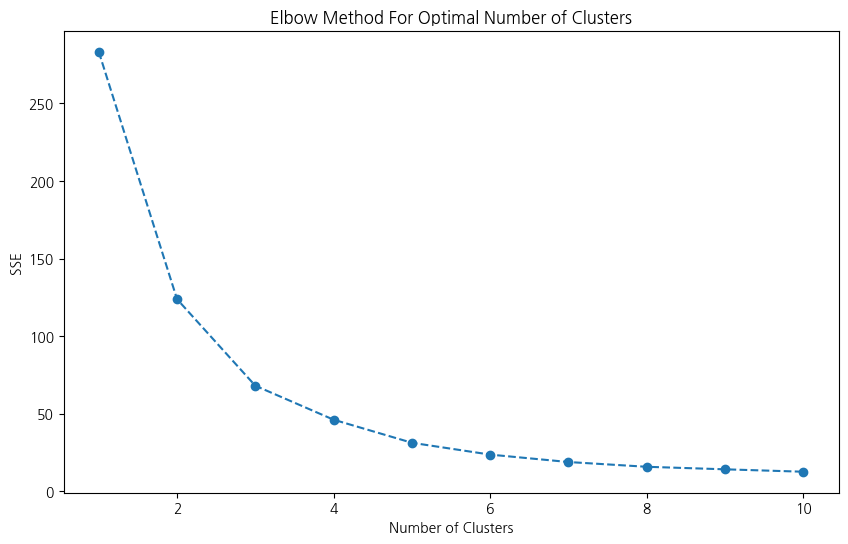

In [26]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(choir_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [53]:
kmeans = KMeans(n_clusters=2, random_state=42)
# 클러스터링 수행
clusters = kmeans.fit_predict(choir_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1}


In [54]:
# 클러스터 결과를 데이터프레임에 추가
choir['cluster'] = clusters

/tmp/ipykernel_7326/4050463235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  choir['cluster'] = clusters


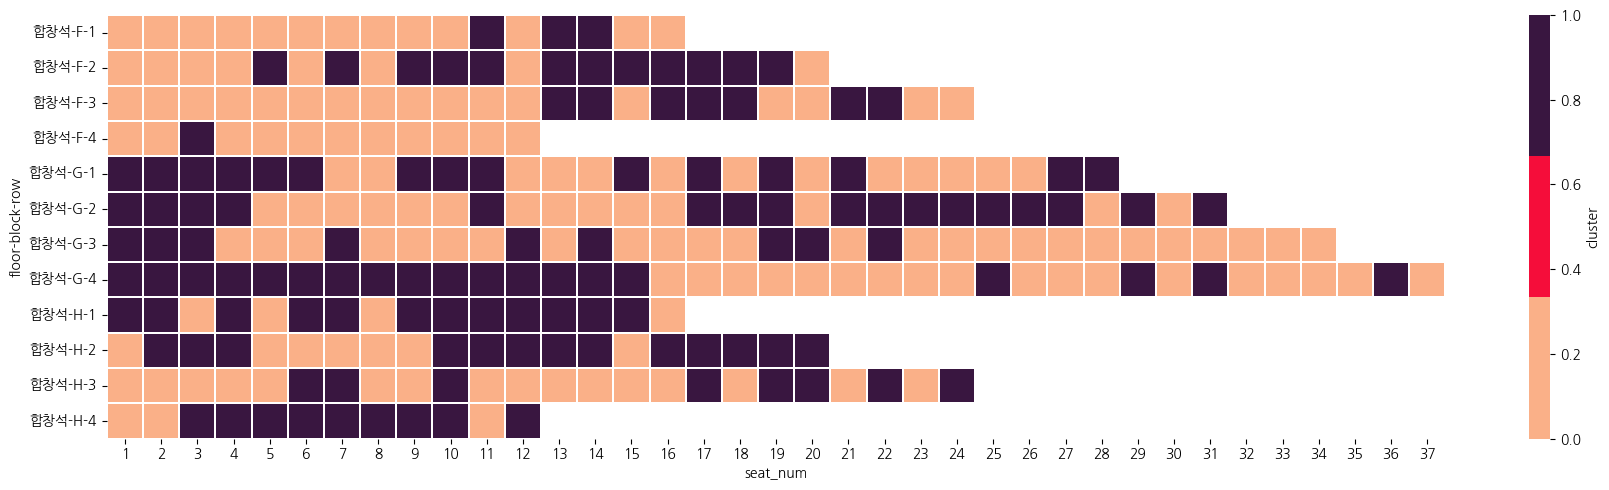

In [55]:
# # 색상 딕셔너리: 각 라벨에 대한 원하는 색상을 지정합니다.
# color_dict = {
    # 0: '#FFD700',  # 파스텔 노랑
    # 1: '#87CEFA',  # 파스텔 블루
    # 2: '#98FB98',  # 파스텔 그린
    # 3: '#FFA07A',  # 파스텔 살몬
    # # 4: '#FFC0CB',  # 파스텔 핑크
    # 5: '#DDA0DD',  # 파스텔 퍼플
    # 6: '#FFB6C1',  # 파스텔 라벤더
    # 7: '#87CEEB',  # 파스텔 스카이 블루
    # 8: '#F0E68C'   # 파스텔 카나리아 옐로우
    # 추가 라벨 및 색상 지정 가능
# }

# color_dict = {
#     0: '#D9213B',  # 빨강
#     1: '#FFB6C1',   # 파스텔 라벤더
#     2: '#1C6DAB',  # 파랑
#     3: '#000000',  # 검정
#     4: '#8E7845',  # 골드
#     5: '#878887',  # 진한회색
#     6: '#59355D',  # 보라
#     7: '#33A295',  # 초록
#     8: '#533D31',  # 갈색
# }

color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}

# 데이터 추출
grouped_data_cluster = choir.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(18,5))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.01)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [33]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(choir_std, labels, metric='euclidean')

0.4800043049338926

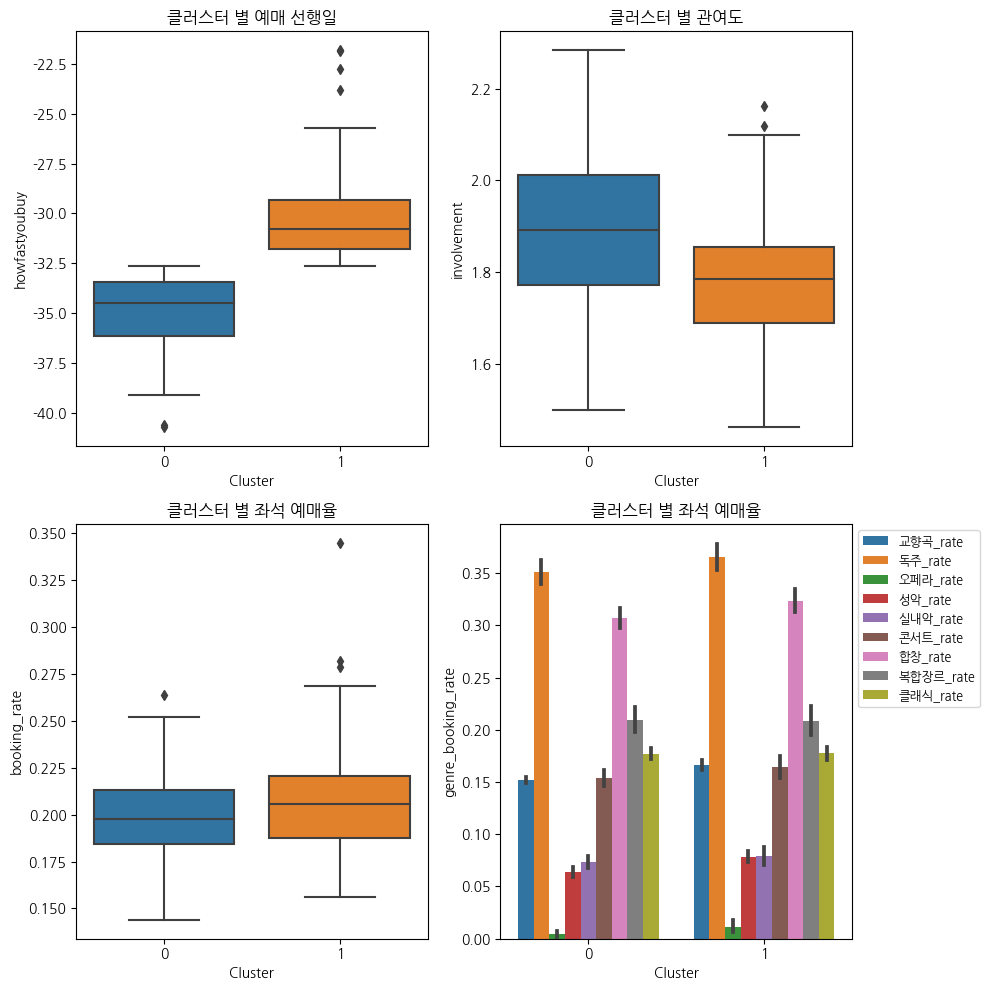

In [37]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=choir, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=choir, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=choir, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(choir, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)


plt.tight_layout()
plt.show()


## 중앙

In [67]:
center = temp[temp['seat_sight']=='중앙']
center.shape

(1267, 18)

In [68]:
center.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/442116602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center.drop(['seat_sight'], axis=1, inplace=True)


In [69]:
# Standard Scaling (표준화)
scaler = StandardScaler()
center_std = center.copy()
center_std[['howfastyoubuy']] = scaler.fit_transform(center_std[['howfastyoubuy']])

In [70]:
center_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [71]:
# 차원축소
pca = PCA(n_components=2)
center_std = pca.fit_transform(center_std)

pca.explained_variance_ratio_

array([0.80704764, 0.08317752])

In [72]:
pca.explained_variance_ratio_.sum()

0.8902251634910814

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

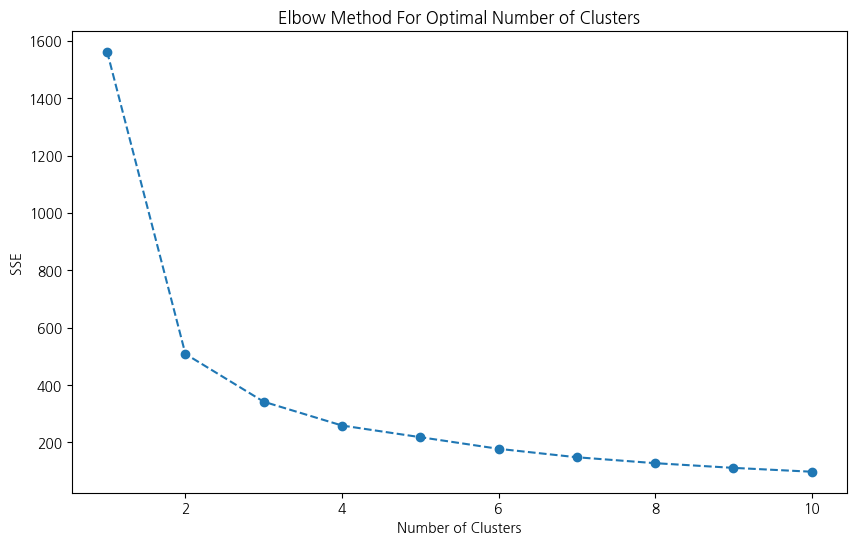

In [44]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(center_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [73]:
kmeans = KMeans(n_clusters=3, random_state=42)
# 클러스터링 수행
clusters = kmeans.fit_predict(center_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1, 2}


In [74]:
# 클러스터 결과를 데이터프레임에 추가
center['cluster'] = clusters

/tmp/ipykernel_7326/2027908941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center['cluster'] = clusters


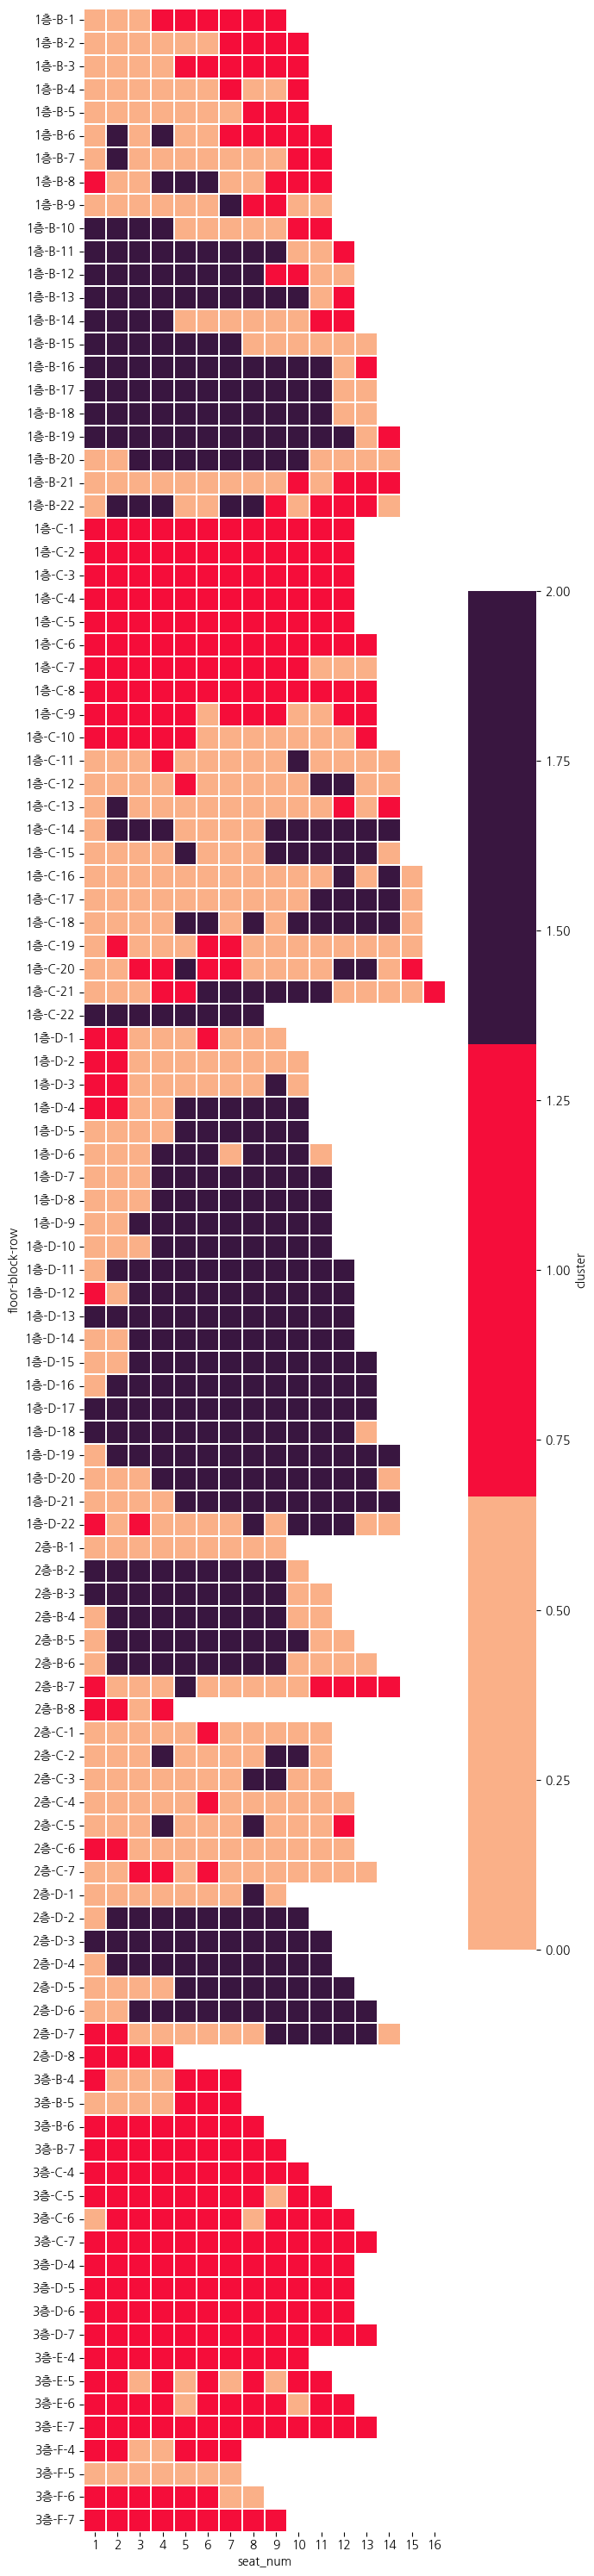

In [75]:
# 데이터 추출
grouped_data_cluster = center.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(7,30))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.05)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [76]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(center_std, labels, metric='euclidean')

0.4430079401883967

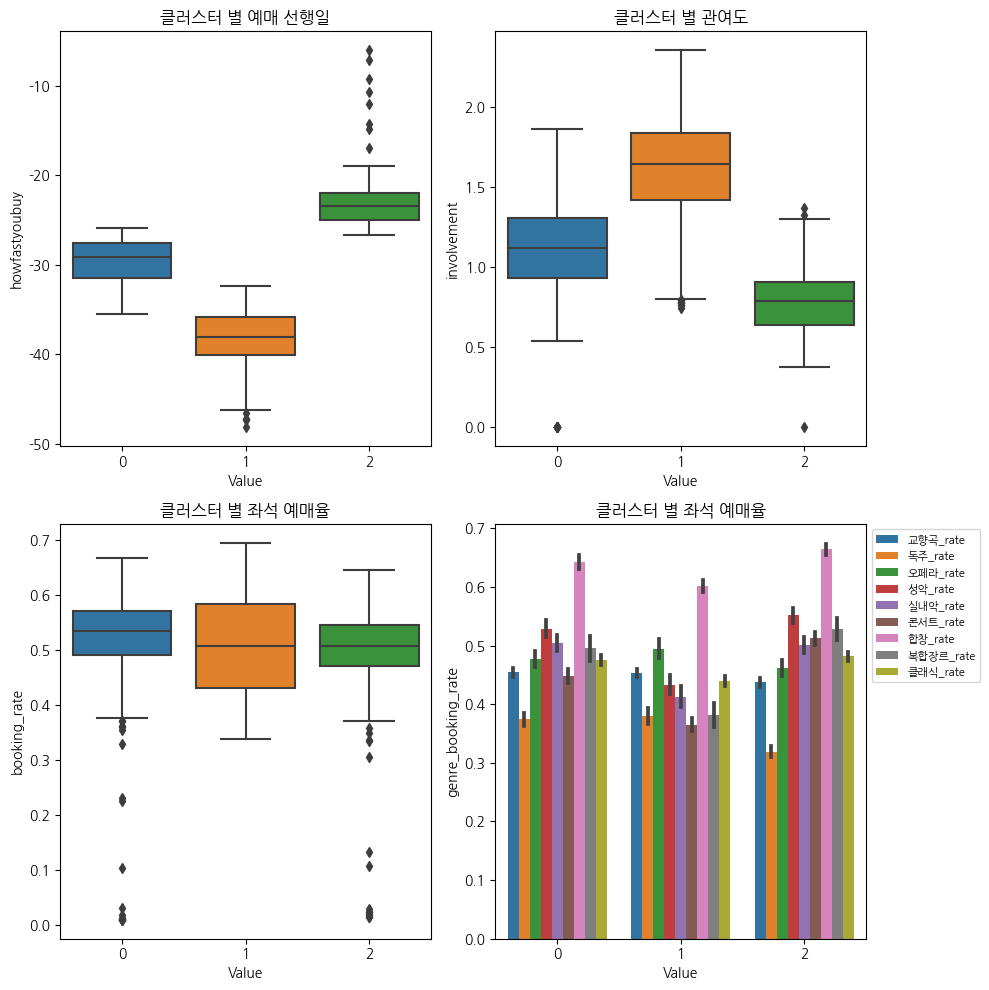

In [77]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=center, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_xlabel('Value')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=center, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_xlabel('Value')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=center, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_xlabel('Value')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(center, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Value')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


plt.tight_layout()
plt.show()


## 시야제한

In [78]:
dark = temp[temp['seat_sight']=='시야제한']
dark.shape

(226, 18)

In [79]:
dark.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/3478664108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dark.drop(['seat_sight'], axis=1, inplace=True)


In [80]:
# Standard Scaling (표준화)
scaler = StandardScaler()
dark_std = dark.copy()
dark_std[['howfastyoubuy']] = scaler.fit_transform(dark_std[['howfastyoubuy']])

In [81]:
dark_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [82]:
# 차원축소
pca = PCA(n_components=3)
dark_std = pca.fit_transform(dark_std)

pca.explained_variance_ratio_

array([0.9191867 , 0.03494674, 0.01810595])

In [83]:
pca.explained_variance_ratio_.sum()

0.9722393839349086

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

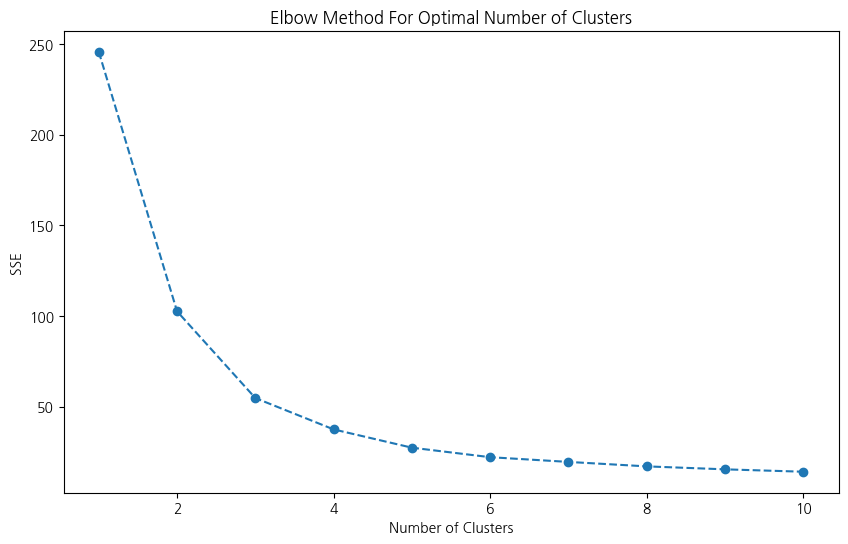

In [84]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dark_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [85]:
kmeans = KMeans(n_clusters=2, random_state=42)
# 클러스터링 수행
clusters = kmeans.fit_predict(dark_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1}


In [86]:
# 클러스터 결과를 데이터프레임에 추가
dark['cluster'] = clusters

/tmp/ipykernel_7326/3216558262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dark['cluster'] = clusters


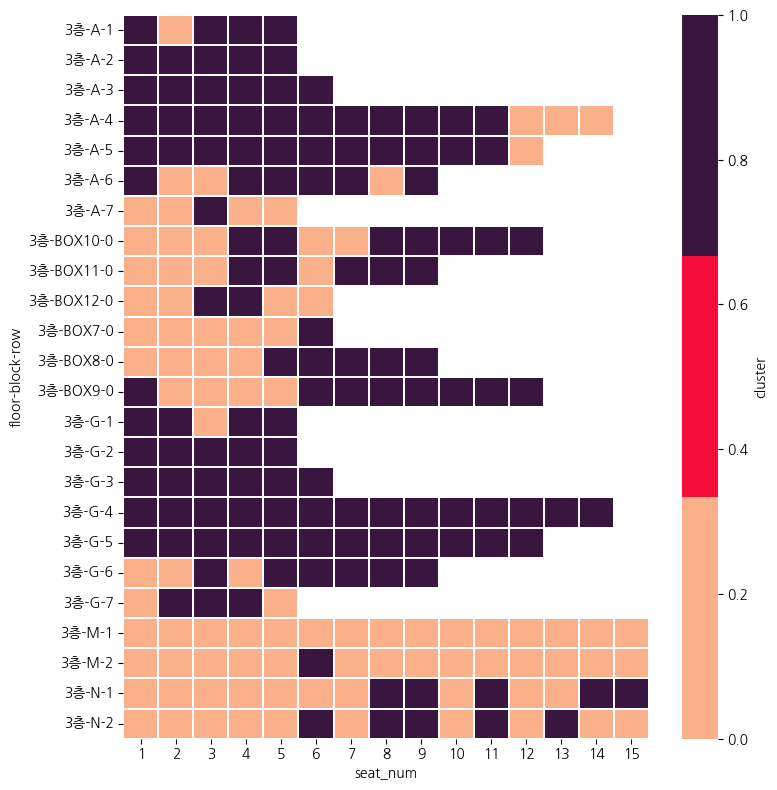

In [88]:
# 데이터 추출
grouped_data_cluster = dark.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.01)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [89]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(dark_std, labels, metric='euclidean')

0.4878938775238984

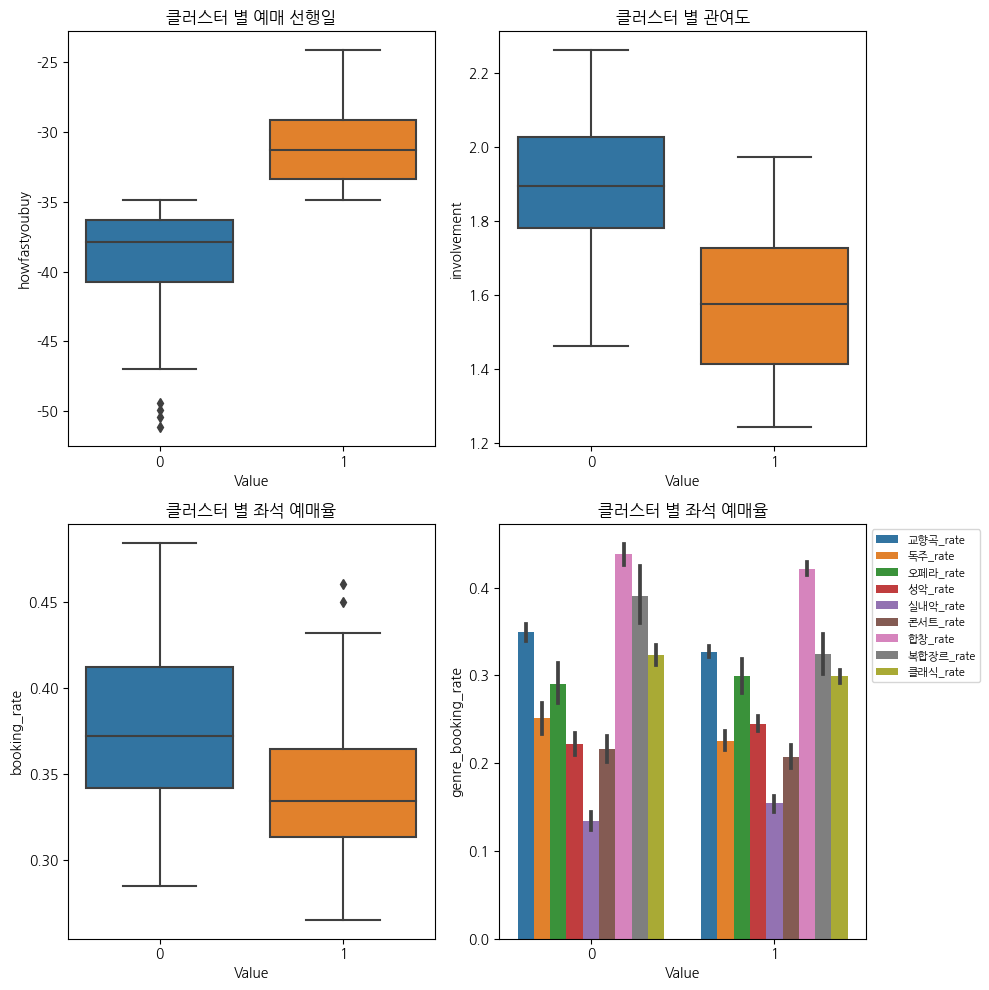

In [148]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=dark, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_xlabel('Value')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=dark, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_xlabel('Value')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=dark, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_xlabel('Value')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(dark, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Value')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


plt.tight_layout()
plt.show()


## 측면

In [90]:
side = temp[temp['seat_sight']=='측면']
side.shape

(742, 18)

In [91]:
side.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/3010259745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  side.drop(['seat_sight'], axis=1, inplace=True)


In [92]:
# Standard Scaling (표준화)
scaler = StandardScaler()
side_std = side.copy()
side_std[['howfastyoubuy']] = scaler.fit_transform(side_std[['howfastyoubuy']])

In [93]:
side_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [94]:
# 차원축소
pca = PCA(n_components=2)
side_std = pca.fit_transform(side_std)

pca.explained_variance_ratio_

array([0.83726854, 0.06825759])

In [95]:
pca.explained_variance_ratio_.sum()

0.9055261226343915

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

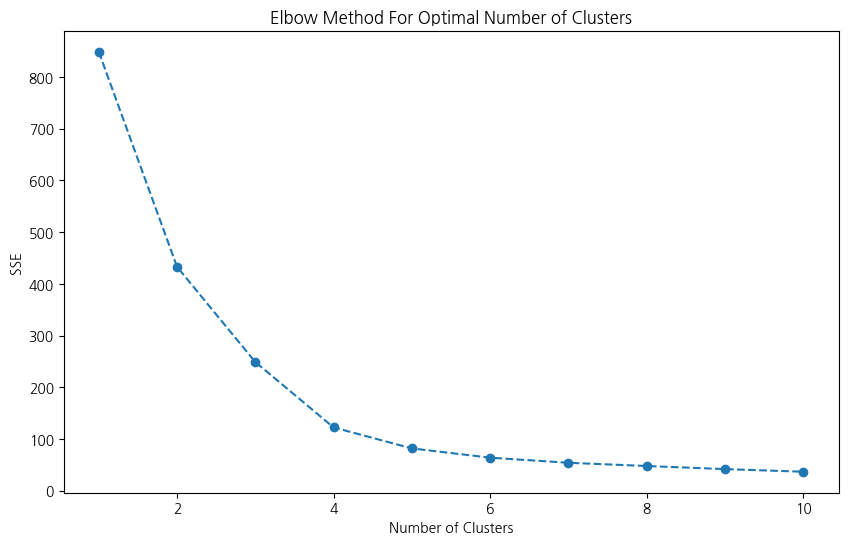

In [165]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(side_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [96]:
kmeans = KMeans(n_clusters=2, random_state=42)
# 클러스터링 수행
clusters = kmeans.fit_predict(side_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1}


In [97]:
# 클러스터 결과를 데이터프레임에 추가
side['cluster'] = clusters

/tmp/ipykernel_7326/2345157216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  side['cluster'] = clusters


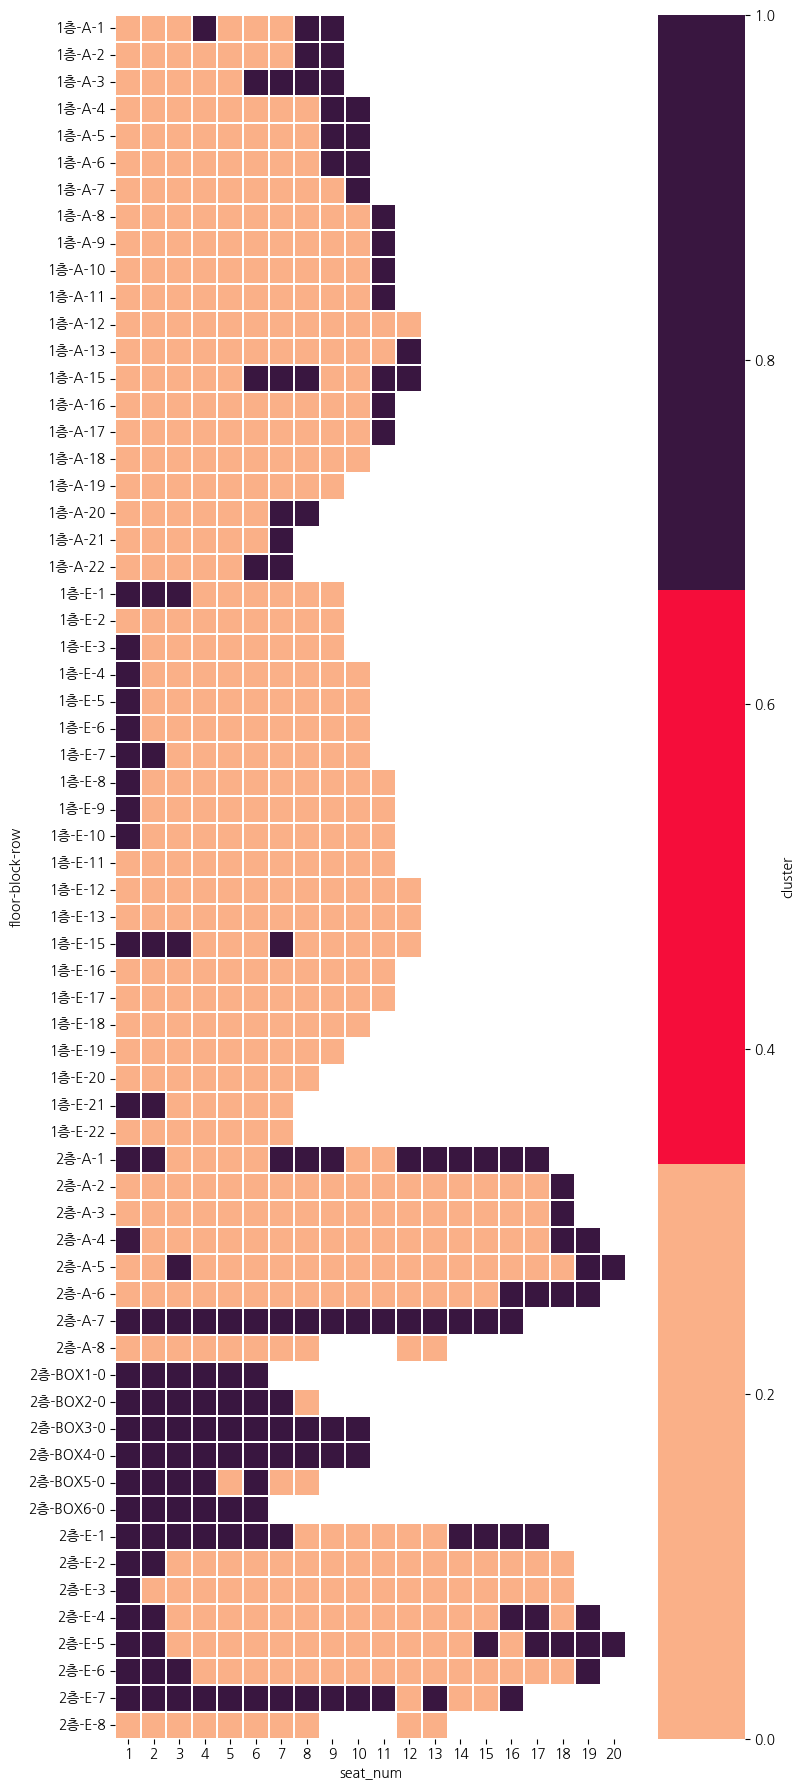

In [103]:
# 데이터 추출
grouped_data_cluster = side.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(8,18))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.01)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [104]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(side_std, labels, metric='euclidean')

0.5382868256930065

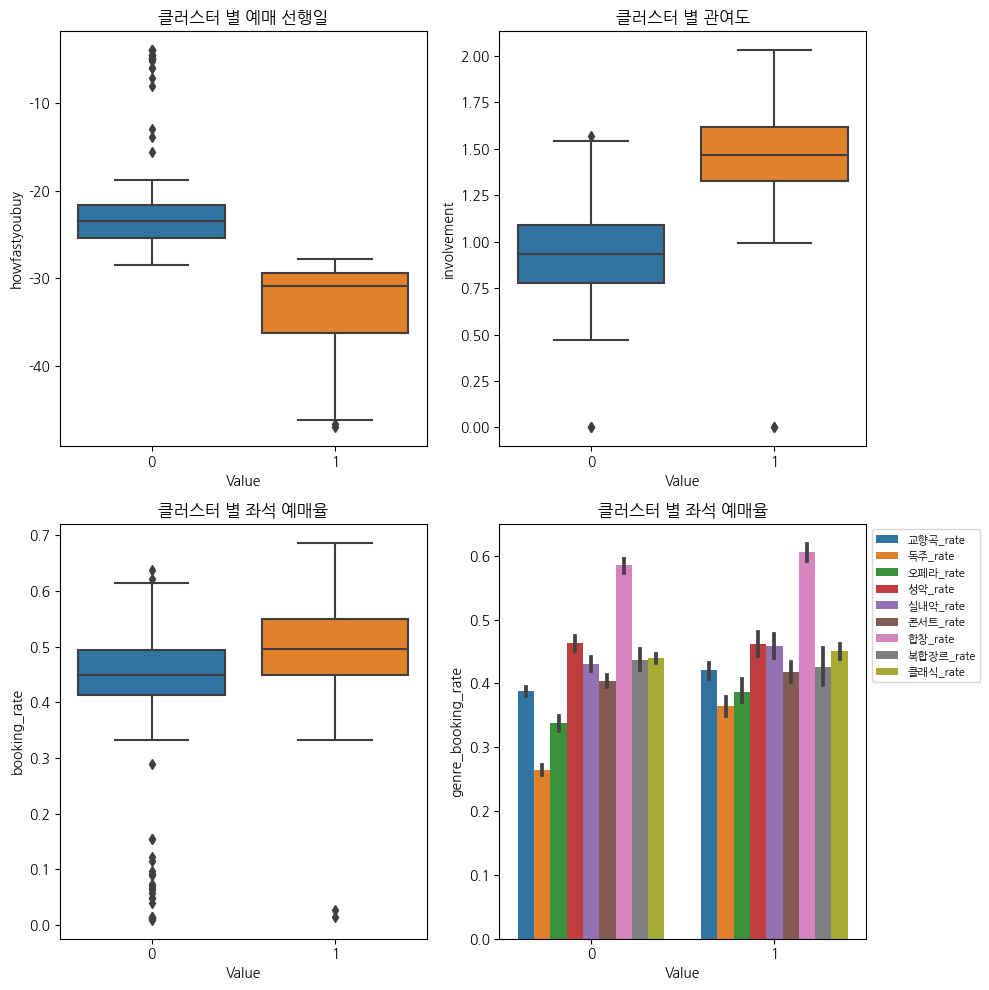

In [170]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=side, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_xlabel('Value')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=side, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_xlabel('Value')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=side, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_xlabel('Value')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(side, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Value')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


plt.tight_layout()
plt.show()


# 층 기준 clustering

In [20]:
temp['floor'].unique()

array(['1층', '2층', '3층', '합창석'], dtype=object)

## 2층

In [105]:
second = temp[temp['floor']=='2층']
second.shape

(572, 18)

In [106]:
second.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/339045945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second.drop(['seat_sight'], axis=1, inplace=True)


In [107]:
# Standard Scaling (표준화)
scaler = StandardScaler()
second_std = second.copy()
second_std[['howfastyoubuy']] = scaler.fit_transform(second_std[['howfastyoubuy']])

In [108]:
second_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [109]:
# 차원축소
pca = PCA(n_components=3)
choir_std = pca.fit_transform(second_std)

pca.explained_variance_ratio_

array([0.84799155, 0.05758173, 0.04557927])

In [110]:
pca.explained_variance_ratio_.sum()

0.9511525515524765

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

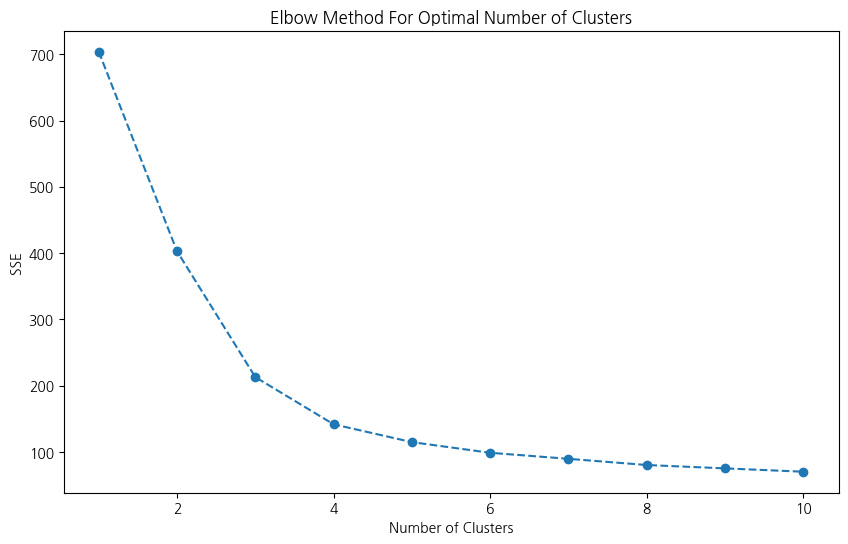

In [111]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(second_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [112]:
kmeans = KMeans(n_clusters=2, random_state=36)
# 클러스터링 수행
clusters = kmeans.fit_predict(second_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1}


In [113]:
# 클러스터 결과를 데이터프레임에 추가
second['cluster'] = clusters

/tmp/ipykernel_7326/471697233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second['cluster'] = clusters


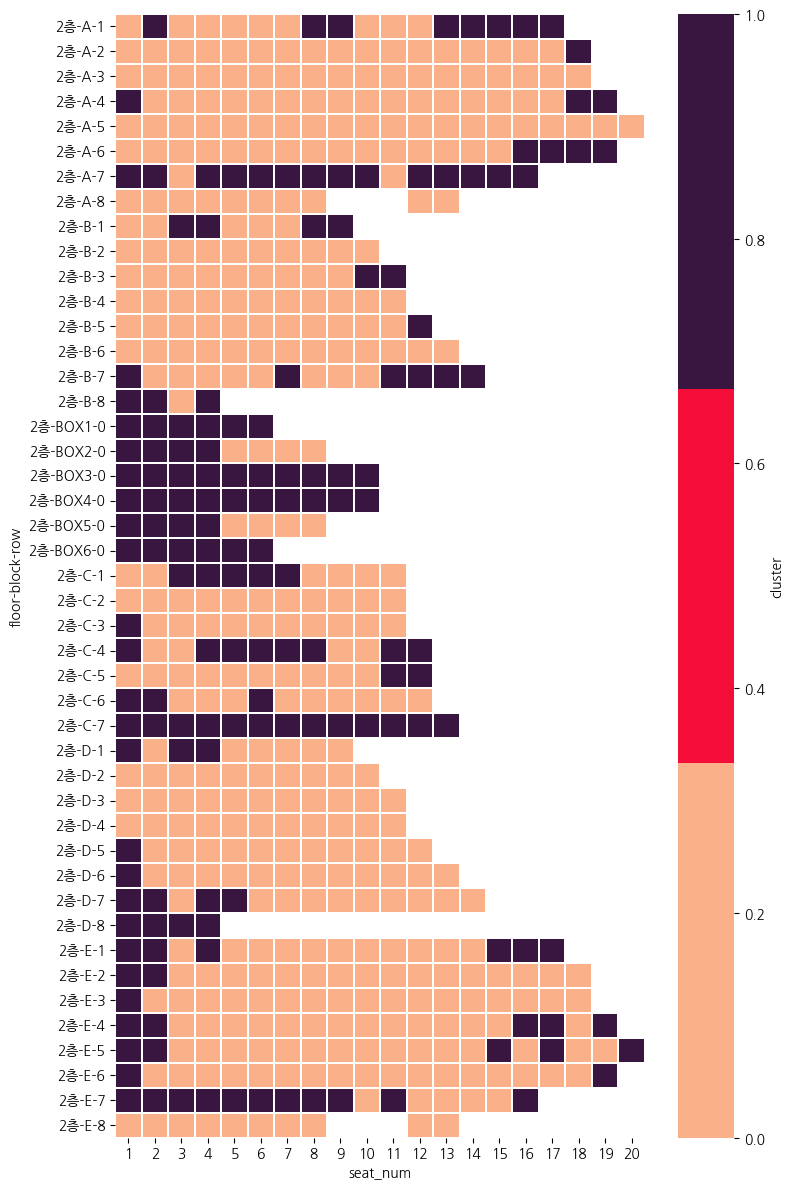

In [123]:
# 데이터 추출
grouped_data_cluster = second.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(8, 12))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.01)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [124]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(second_std, labels, metric='euclidean')

0.4466812445808659

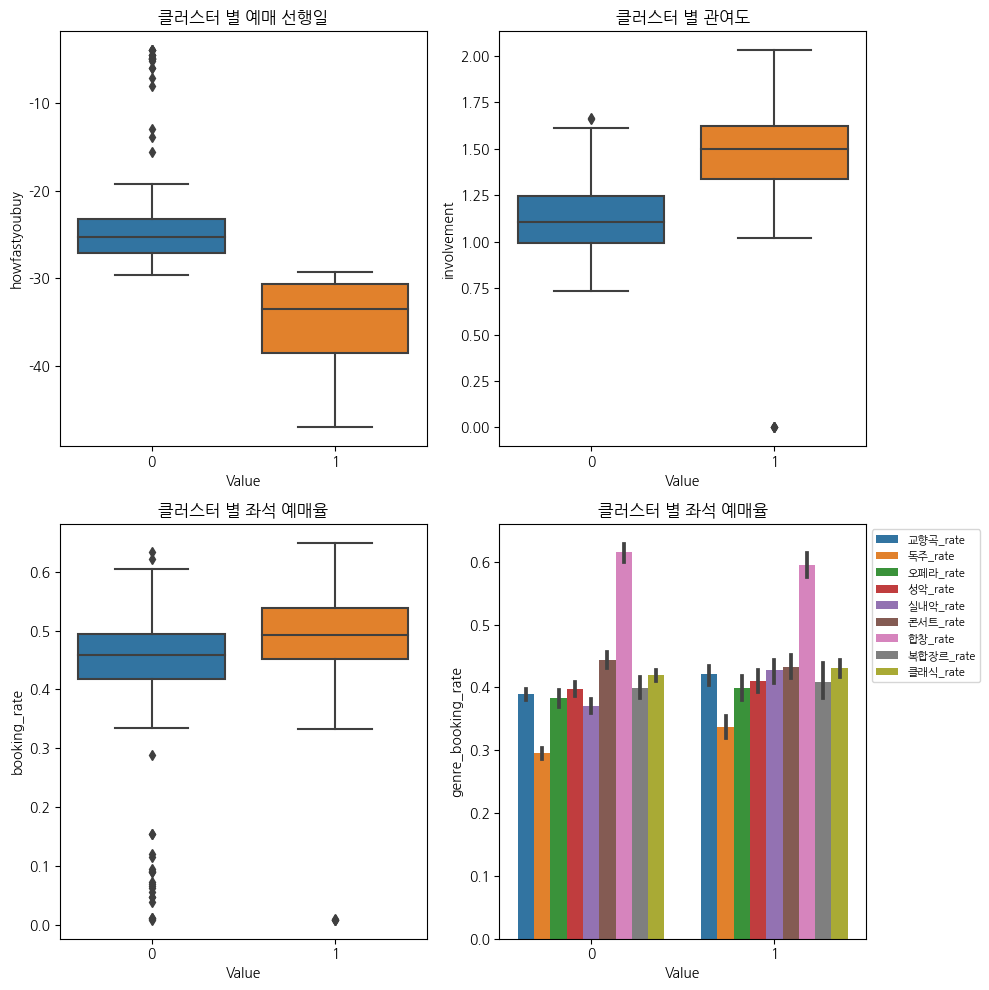

In [125]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=second, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_xlabel('Value')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=second, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_xlabel('Value')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=second, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_xlabel('Value')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(second, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Value')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


plt.tight_layout()
plt.show()


## 1층

In [126]:
first = temp[temp['floor']=='1층']
first.shape

(1234, 18)

In [127]:
first.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/3905715405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first.drop(['seat_sight'], axis=1, inplace=True)


In [128]:
# Standard Scaling (표준화)
scaler = StandardScaler()
first_std = first.copy()
first_std[['howfastyoubuy']] = scaler.fit_transform(first_std[['howfastyoubuy']])

In [129]:
first_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [130]:
# 차원축소
pca = PCA(n_components=3)
choir_std = pca.fit_transform(first_std)

pca.explained_variance_ratio_

array([0.83325297, 0.05734206, 0.05114225])

In [131]:
pca.explained_variance_ratio_.sum()

0.9417372736867667

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

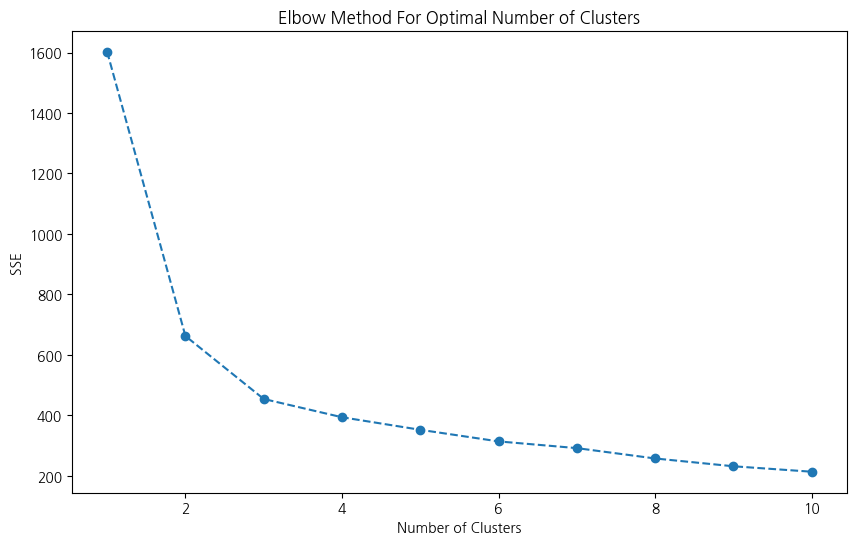

In [132]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(first_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [133]:
kmeans = KMeans(n_clusters=3, random_state=36)
# 클러스터링 수행
clusters = kmeans.fit_predict(first_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1, 2}


In [134]:
# 클러스터 결과를 데이터프레임에 추가
first['cluster'] = clusters

/tmp/ipykernel_7326/970069229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first['cluster'] = clusters


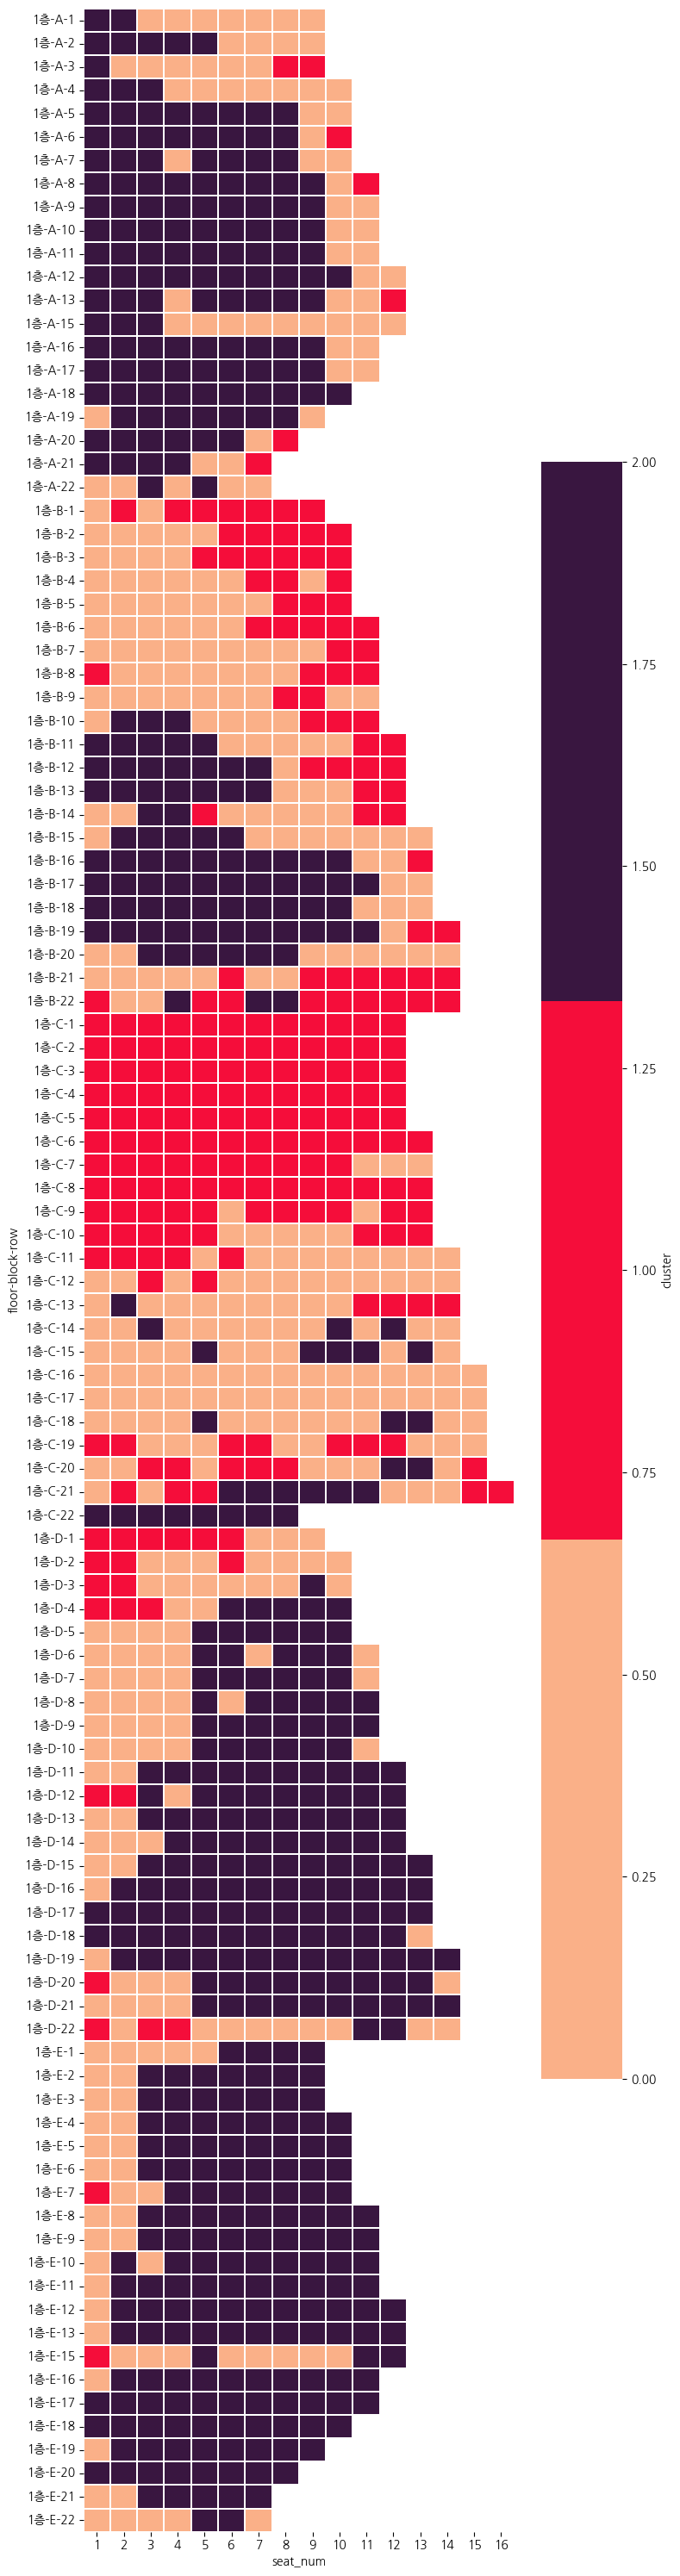

In [137]:
# 데이터 추출
grouped_data_cluster = first.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(8,30))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.01)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [138]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(first_std, labels, metric='euclidean')

0.3784947178613943

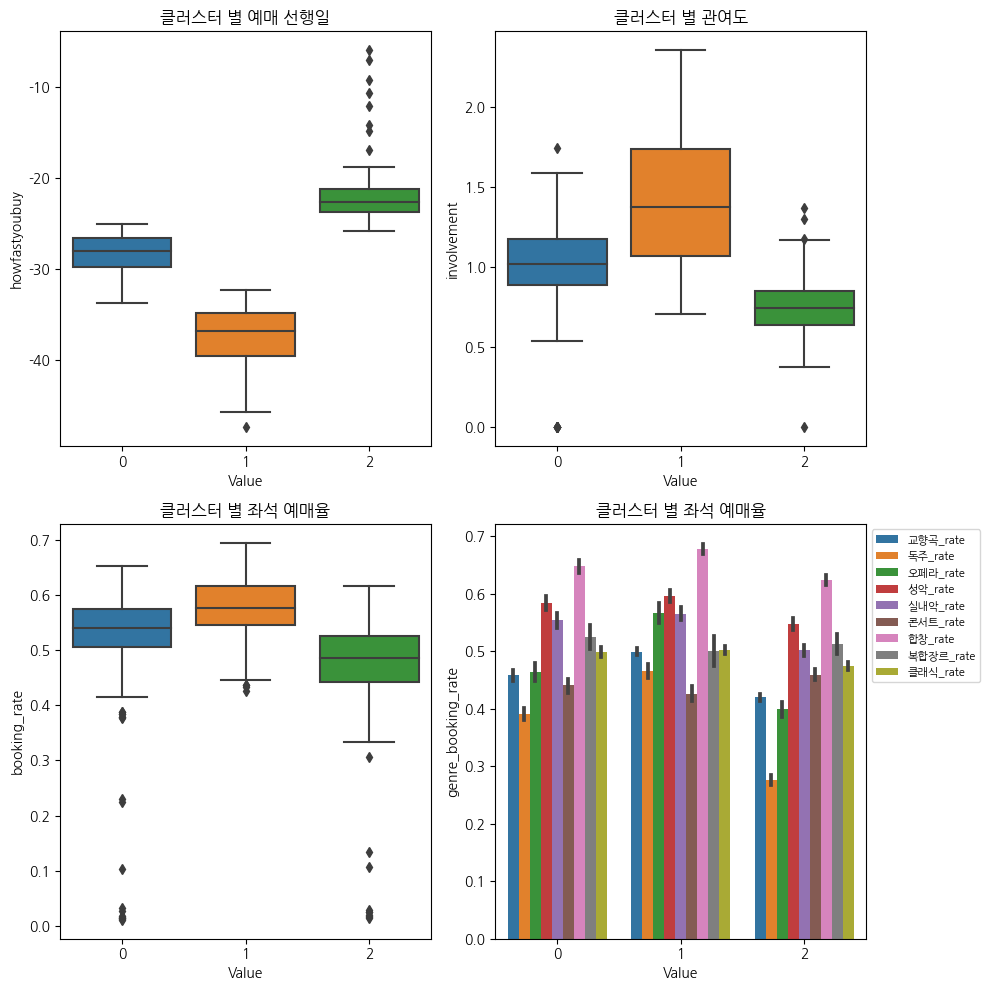

In [139]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=first, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_xlabel('Value')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=first, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_xlabel('Value')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=first, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_xlabel('Value')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(first, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Value')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


plt.tight_layout()
plt.show()


## 3층

In [140]:
third = temp[temp['floor']=='3층']
third.shape

(429, 18)

In [141]:
third.drop(['seat_sight'], axis=1, inplace=True)

/tmp/ipykernel_7326/3659290711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third.drop(['seat_sight'], axis=1, inplace=True)


In [142]:
# Standard Scaling (표준화)
scaler = StandardScaler()
third_std = third.copy()
third_std[['howfastyoubuy']] = scaler.fit_transform(third_std[['howfastyoubuy']])

In [143]:
third_std.drop(['seat', 'floor', 'block', 'row', 'seat_num'], axis=1, inplace=True)

In [144]:
# 차원축소
pca = PCA(n_components=3)
choir_std = pca.fit_transform(third_std)

pca.explained_variance_ratio_

array([0.90122962, 0.03886011, 0.02394985])

In [145]:
pca.explained_variance_ratio_.sum()

0.9640395694463183

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

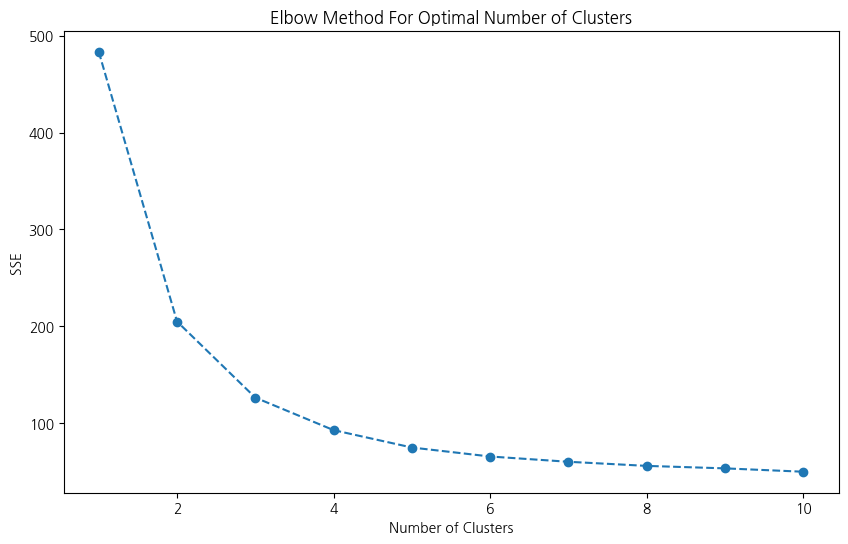

In [146]:
# 엘보우 구하기

# 클러스터의 수 범위 설정
range_n_clusters = range(1, 11)
# 각 클러스터 수에 대한 SSE 값을 저장할 리스트
sse = []

# 각 클러스터 수에 대해 KMeans 클러스터링 수행
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(third_std)
    sse.append(kmeans.inertia_)  # inertia_ 속성은 SSE 값을 나타냄

# Elbow 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [147]:
kmeans = KMeans(n_clusters=2, random_state=36)
# 클러스터링 수행
clusters = kmeans.fit_predict(third_std)
print(set(clusters))

/home/finda/.conda/envs/ryu/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1}


In [148]:
# 클러스터 결과를 데이터프레임에 추가
third['cluster'] = clusters

/tmp/ipykernel_7326/3654414905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third['cluster'] = clusters


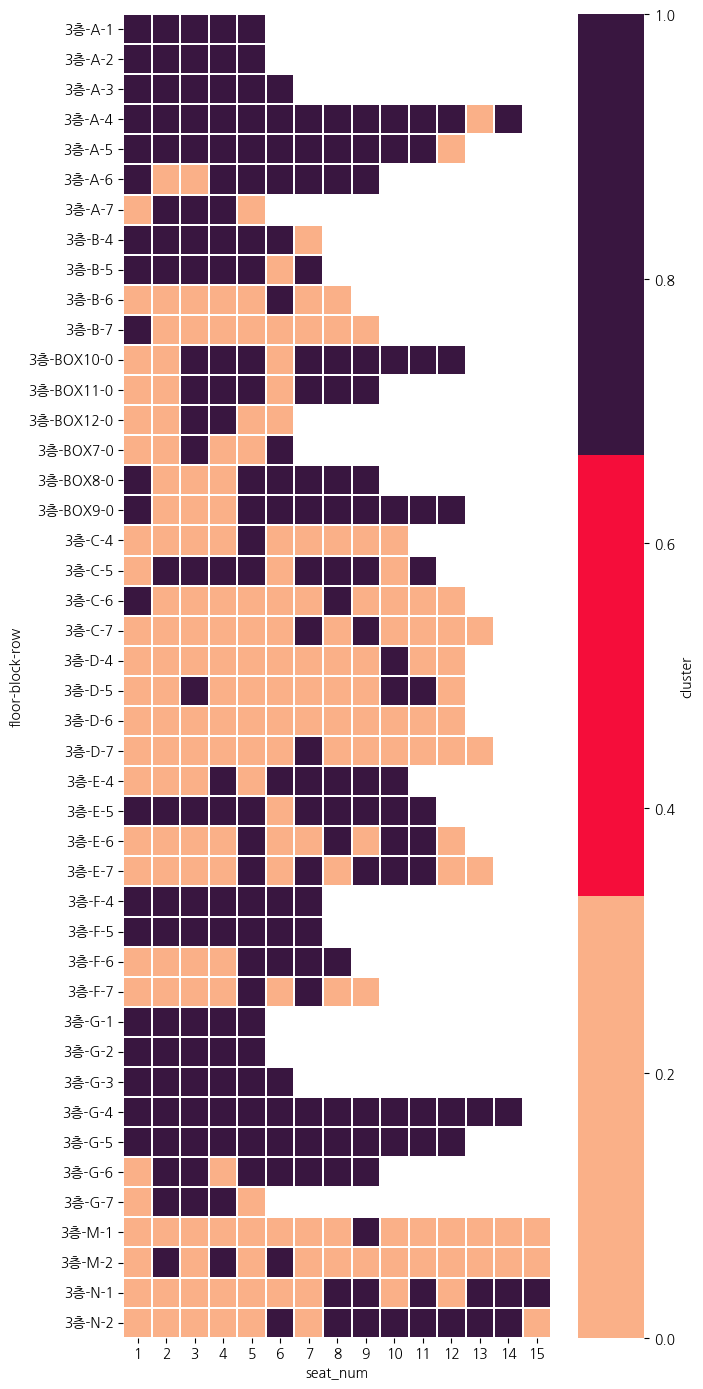

In [159]:
# 데이터 추출
grouped_data_cluster = third.groupby(['floor', 'block', 'row', 'seat_num'])['cluster'].unique().astype(int).reset_index().sort_values(by=['floor', 'block', 'row', 'seat_num'])

# 데이터 피봇
heatmap_data_cluster = grouped_data_cluster.pivot_table(index=['floor', 'block', 'row'], columns='seat_num', values='cluster')

# 색상 맵 생성
color_dict = {0: '#FAB088', 1: '#F50D3A', 2: '#391640'}
cmap = sns.color_palette([color_dict[i] for i in range(len(color_dict))])

# 시각화
fig, ax = plt.subplots(figsize=(7, 14))

sns.heatmap(heatmap_data_cluster, ax=ax, cmap=cmap, cbar_kws={'label': 'cluster'}, linewidth=0.01)
# ax.set_title('Heatmap of Seat Clusters')

plt.tight_layout()
plt.show()

In [87]:
from sklearn import metrics

labels = kmeans.labels_
metrics.silhouette_score(third_std, labels, metric='euclidean')

0.456789802003189

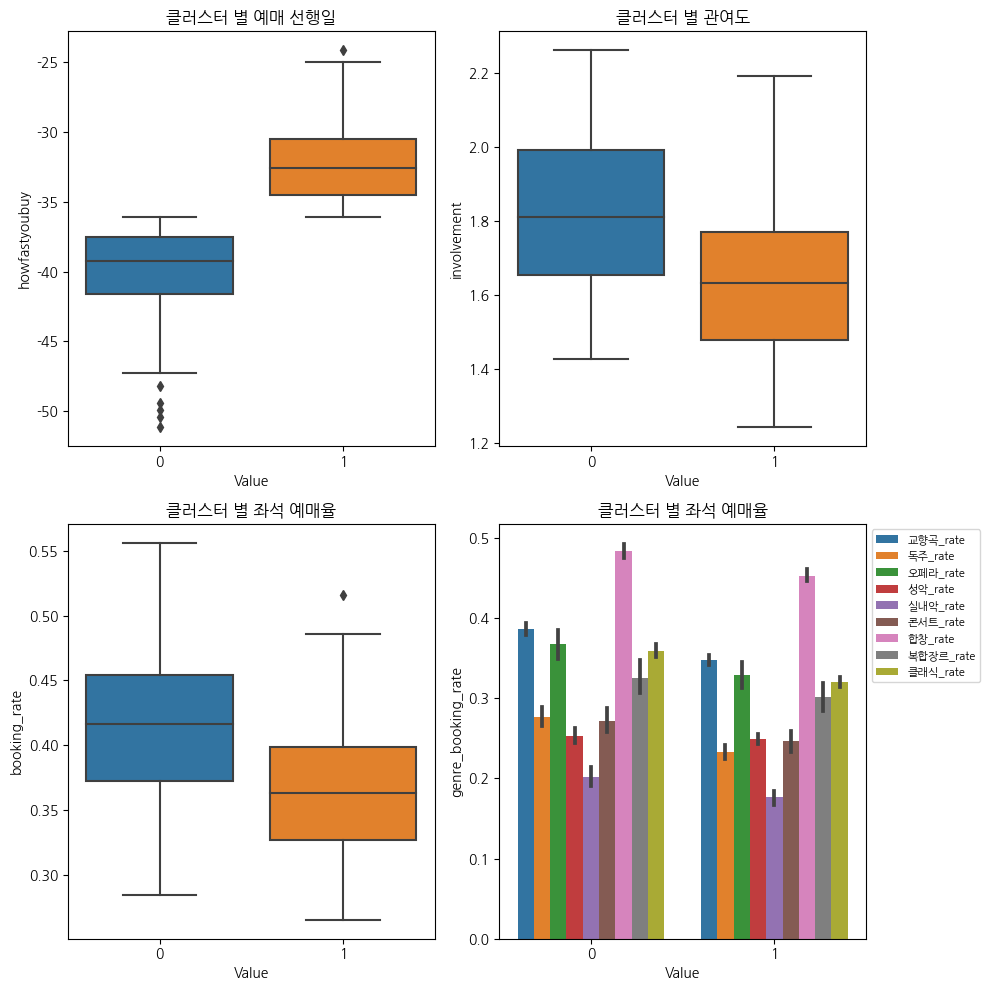

In [160]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.boxplot(x="cluster", y="howfastyoubuy", data=third, ax=axes[0,0])
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_xlabel('Value')
axes[0,0].set_title('클러스터 별 예매 선행일')

sns.boxplot(x="cluster", y="involvement", data=third, ax=axes[0,1])
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_xlabel('Value')
axes[0,1].set_title('클러스터 별 관여도')

sns.boxplot(x="cluster", y="booking_rate", data=third, ax=axes[1,0])
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_xlabel('Value')
axes[1,0].set_title('클러스터 별 좌석 예매율')

# 데이터 재구조화
df_melted = pd.melt(third, id_vars=["cluster"], value_vars=['교향곡_rate', '독주_rate', '오페라_rate', '성악_rate', '실내악_rate',
        '콘서트_rate', '합창_rate', '복합장르_rate', '클래식_rate'], var_name="genre", value_name="genre_booking_rate")
# 막대그래프 그리기
sns.barplot(x="cluster", y="genre_booking_rate", hue="genre", data=df_melted, ax=axes[1,1])
axes[1,1].set_xlabel('Value')
axes[1,1].set_title('클러스터 별 좌석 예매율')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


plt.tight_layout()
plt.show()
